# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go

In [2]:
# Завантаження даних
df = pd.read_csv('../data/credit_risk_dataset.csv')

In [3]:
# Розмір датасету
df.shape

(32581, 12)

In [4]:
# Перші 5 рядків
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
# Загальна інформація про дані
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

Розподіл вибірки 78% сплачено, 22% не сплачено. Відповідно маємо задачу незбалансованої класифікації


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [7]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Маємо пропущені значення в колонках person_emp_length та loan_int_rate. Обидві мають тип  float64, відповідно заповнимо пропущені значення медіаною.

In [8]:
# Заповнення пропусків медіаною
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [9]:
# Аналіз розподілу числових змінних
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.767994,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.087372,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


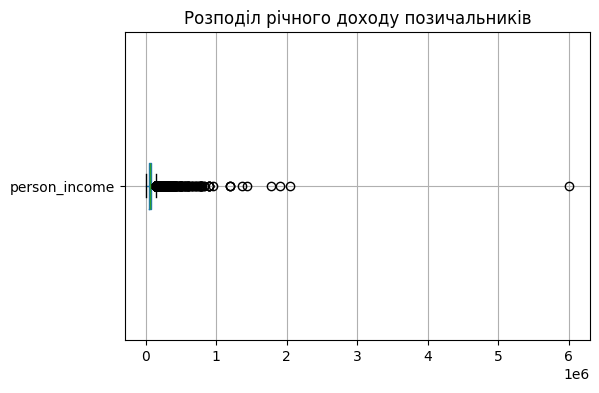

In [10]:
df[['person_income']].boxplot(
    figsize = (6, 4), 
    xlabel = ' ',
    vert = False
)
plt.title('Розподіл річного доходу позичальників')
plt.suptitle('');

Аналіз розподілу показує сильне зміщення вправо по показнику доходу позичальника. Медіана складає 55000, а середнє 66075, за рахунок викидів - є значення, які сягають 6 000 000.
Для коректної роботи моделі потрібно обробити ці викиди за допомогою інтерквартильного розмаху.

Для обробки викидів існує 3 варіанти:
- Видалити рядки, які виходять за межі
- Обмежити дані розрахованими межами (Capping) - нижня межа для лівого хвосту і верхня межа для правого
- Замінити значення на медіану

Так як розподіл має правосторонню асиметрію (мінімальне значення не виходить за 25-й перцентиль), то логічно використати метод обмеження (Capping) для правого хвосту, щоб не втрачати дані через видалення.

In [11]:
## Аналіз викидів
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1
    
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# Маска для викидів
outliers_mask = (df['person_income'] < lower_bound) | (df['person_income'] > upper_bound)

# Статистика по викидам
print(f"Нижня межа: {lower_bound:,.2f}")
print(f"Верхня межа: {upper_bound:,.2f}")
print(f"Кількість викидів: {outliers_mask.sum()} ({outliers_mask.sum()/len(df)*100:.2f}%)")

# Обробка викидів
df_capped = df.copy()
df_capped.loc[df_capped['person_income'] < lower_bound, 'person_income'] = lower_bound
df_capped.loc[df_capped['person_income'] > upper_bound, 'person_income'] = upper_bound

print(f'\nРозподіл доходів позичальників після обробки викидів')
print(df_capped['person_income'].describe())

Нижня межа: -22,550.00
Верхня межа: 140,250.00
Кількість викидів: 1484 (4.55%)

Розподіл доходів позичальників після обробки викидів
count     32581.000000
mean      62419.212793
std       31810.265995
min        4000.000000
25%       38500.000000
50%       55000.000000
75%       79200.000000
max      140250.000000
Name: person_income, dtype: float64


In [12]:
## Аналіз категоріальних змінних

# Кількість унікальних значень для кожної з категоріальних колонок
categorical_columns = df_capped.select_dtypes(include=['object']).columns


for column in categorical_columns:
    unique_count = df_capped[column].nunique()
    print(f'{column}: {unique_count} унікальних значень')

person_home_ownership: 4 унікальних значень
loan_intent: 6 унікальних значень
loan_grade: 7 унікальних значень
cb_person_default_on_file: 2 унікальних значень


In [13]:
# Візуалізація частоти зустрічання числової змінної за значеннями категоріальних змінних

df_viz = df_capped.copy()
df_viz['loan_status_label'] = df_viz['loan_status'].map({0: 'Сплачено', 1: 'Дефолт'})

data_list = []

for col in categorical_columns:
    # Групування по категоріям та статусу
    grouped = df_viz.groupby([col, 'loan_status_label']).size().reset_index(name='count')
    
    # Обчислення відсотків в розрізі категорій
    total_by_category = df_viz.groupby(col).size().reset_index(name='total')
    grouped = grouped.merge(total_by_category, on=col)
    grouped['percentage'] = (grouped['count'] / grouped['total'] * 100).round(2)
    
    # Створюємо комбіновану мітку: "Змінна: Значення"
    grouped['variable'] = col
    grouped['category_label'] = grouped['variable'] + ': ' + grouped[col].astype(str)
    
    data_list.append(grouped)

# Об'єднання даних для відображення
all_data = pd.concat(data_list, ignore_index=True)

# Візуалізація
fig = px.bar(
    all_data,
    y='category_label',
    x='percentage',
    color='loan_status_label',
    title='Розподіл статусу кредиту по категоріальних змінних',
    labels={
        'category_label': 'Категорія',
        'percentage': 'Відсоток (%)',
        'loan_status_label': 'Статус кредиту'
    },
    color_discrete_map={'Сплачено': '#2ecc71', 'Дефолт': '#e74c3c'},
    orientation='h',
    text='percentage'
)

# Налаштування відображення
fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside')
fig.update_layout(
    height=600,
    xaxis_title='Відсоток (%)',
    yaxis_title='',
    legend_title='Статус кредиту',
    barmode='stack',
    yaxis={'categoryorder': 'total ascending'}
)

fig.show()

З графіку видно, що ті хто мав дефолти по кредитам попередньо, мають більшу схильність не погасити і поточний кредит.

Вірогідність дефолту відповідає кредитному рейтингу позичальника (loan_grade) - позичальники з найнижчим рейтингом G мають дефолт в 98,4% випадків.

За метою кредиту більше всього дефолтів за категоріями `DEBTCONSOLIDATION`, `MEDICAL` та `HOMEIMPROVEMENT`.

За типом володіння більше всього дефолтів за категоріями `RENT` та `OTHER`, а менше за все за категорією `OWN`.



---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



In [14]:
# Кореляційна матриця
numerical_cols = df_capped.select_dtypes(include=['int64', 'float64']).columns.tolist()

df_numerical = df_capped[numerical_cols].copy()

correlation_matrix = df_numerical.corr()

fig1 = px.imshow(
    correlation_matrix,
    text_auto='.3f',
    aspect='auto',
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    title='Кореляційна матриця',
    labels=dict(color='Кореляція'),
    zmin=-1, zmax=1
)

fig1.update_layout(
    height=700,
    width=800,
    xaxis_title='',
    yaxis_title=''
)

fig1.show()

Кодувати категоріальні змінні раціонально відповідно до логіки їх значень.

Колонка `cb_person_default_on_file` (Чи є дефолти в історії позичальника) має лише 2 значення Y (так) та N (Ні), тому раціонально замінити значення на 1 та 0.

Колонка `loan_grade` має ранжовані значення рейтингу від найвищого до найнижчого, тому для цієї колонки раціонально застосувати Label Encoding.

В колонках `loan_intent` та `person_home_ownership` значення рівнозначні і їх відносно небагато, тому закодуємо їх методом One-Hot Encoding.

In [15]:
# Перетворення Yes/No на 1/0 для історії дефолту
df_capped['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

In [16]:
# Застосування Label Encoding до колонки loan_grade
loan_grade_mapping = {
    'A': 0,
    'B': 1, 
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

df_capped['loan_grade_encoded'] = df_capped['loan_grade'].map(loan_grade_mapping)

In [17]:
# One-Hot Encoding
loan_intent_dummies = pd.get_dummies(df_capped['loan_intent'], prefix='loan_intent')
person_home_ownership_dummies = pd.get_dummies(df_capped['person_home_ownership'], prefix='home_ownership')

**Аналіз ознак**

Ознака `cb_person_cred_hist_length` (довжина кредитної історії) має тісний зв'язок з `person_age` (віком позичальника). При цьому кредитна історія має трохи сильнішу кореляцію з цільовою ознакою і є більш релевантною для визначення вірогідності дефолту, а вік не визначає кредитоспроможність. Тому раціюнально залишити для моделі `cb_person_cred_hist_length`, а `person_age` - видалити.

loan_percent_income є похідною від loan_amnt та person_income, проте усі три ознааки несуть інформацію для моделі. На поточний момент залишаємо усі ці ознаки, а після побудови моделі можна буде видалити, наприклад, loan_amnt (як змінну з найменшою з трьох кореляцією до цільової) і перевірити чи підвищиться якість моделі.

Для моделі залишаємо закодовані категоріальні змінні, та обрані числові.

In [18]:
# Формування фінального датасету для моделі

df_capped_enr = pd.concat([
    df_capped.select_dtypes(include=['number']),
    loan_intent_dummies,
    person_home_ownership_dummies,], axis=1)

df_capped_enr.drop(columns=['person_age'])

df_capped_enr.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_grade_encoded,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,22,59000,123.0,35000,16.02,1,0.59,1,3,3,False,False,False,False,True,False,False,False,False,True
1,21,9600,5.0,1000,11.14,0,0.10,0,2,1,False,True,False,False,False,False,False,False,True,False
2,25,9600,1.0,5500,12.87,1,0.57,0,3,2,False,False,False,True,False,False,True,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,0,2,2,False,False,False,True,False,False,False,False,False,True
4,24,54400,8.0,35000,14.27,1,0.55,1,4,2,False,False,False,True,False,False,False,False,False,True


In [19]:
# Ще раз перевіримо на порожні значення після усіх модифікацій
df_capped_enr.isnull().sum()

person_age                       0
person_income                    0
person_emp_length                0
loan_amnt                        0
loan_int_rate                    0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_grade_encoded               0
loan_intent_DEBTCONSOLIDATION    0
loan_intent_EDUCATION            0
loan_intent_HOMEIMPROVEMENT      0
loan_intent_MEDICAL              0
loan_intent_PERSONAL             0
loan_intent_VENTURE              0
home_ownership_MORTGAGE          0
home_ownership_OTHER             0
home_ownership_OWN               0
home_ownership_RENT              0
dtype: int64


---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [20]:
# Визначимо X та y
y = df_capped_enr['loan_status']
X = df_capped_enr.drop('loan_status', axis=1)

print(f"\nРозмір X (ознак): {X.shape}")
print(f"Розмір y (цілі): {y.shape}")


Розмір X (ознак): (32581, 19)
Розмір y (цілі): (32581,)


In [21]:
from sklearn.preprocessing import StandardScaler

# Створюємо та застосовуємо скейлер для стандартизації X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Перетворюємо назад у DataFrame для зручності
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [22]:
from sklearn.model_selection import train_test_split

# Розділяємо дані: 80% на навчання, 20% на тест

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y,
    test_size=0.2,  # 20% даних йде на тест
    random_state=42  # фіксуємо випадковість для відтворюваності
)

In [23]:
from sklearn.linear_model import LogisticRegression

# Створюємо та навчаємо модель
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

print("Модель навчена!")

Модель навчена!


In [24]:
# Прогнозуємо класи на тренувальній вибірці
y_pred_t = model.predict(X_train)

# Прогнозуємо ймовірності на тренувальній вибірці
y_pred_proba_t = model.predict_proba(X_train)

# Прогнозуємо класи на тесті
y_pred = model.predict(X_test)

# Прогнозуємо ймовірності на тесті
y_pred_proba = model.predict_proba(X_test)

In [25]:
# Приклад прогнозів для перших 5 клієнтів
sample_predictions = pd.DataFrame({
    'Реальний дефолт': y_test.values[:5],
    'Прогноз': y_pred[:5],
    'Ймовірність погашення': y_pred_proba[:5, 0].round(3),
    'Ймовірність дефолту': y_pred_proba[:5, 1].round(3)
})
print(sample_predictions)

   Реальний дефолт  Прогноз  Ймовірність погашення  Ймовірність дефолту
0                0        0                  0.734                0.266
1                0        0                  0.749                0.251
2                0        0                  0.694                0.306
3                1        1                  0.437                0.563
4                1        1                  0.066                0.934



---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


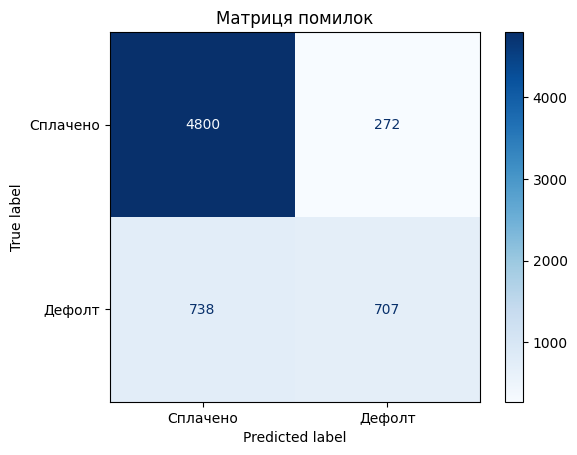

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплачено', 'Дефолт'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()

Відповідно до матриці помилок, модель коректно визначає успішну сплату кредиту у 86% випадків і дефолт в 72% випадків

Базуючись на отриманих результатах в подальшому можна оцінити величину втрат - в 14% випадків помилково спрогнозовано дефолт, таким клієнтам буде відмовлено в кредиті - це недоотриманий прибуток. В 28% випадків помилково спрогнозовано виплату - це прямі збитки.

Медіанне значення суми кредиту 8000, отже грубо обчислені прямі втрати із-за помилково наданих кредитів 738 * 8000 = 5 904 000. А зважаючи на правосторонню асиметрію, втрати будуть більшими. Плюс недоотримані доходи у вигляді відсотків 11% річних (медіана) 649 440. Усього більш ніж 6,5 млн втрат як наслідок невиявлених дефолтів.

Для помилково спрогнозованих дефолтів грубо оцінені недоотримані витрати складуть 8000 * 0,11 * 272 = 239 360 на рік

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Аналіз якості моделі

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("МЕТРИКИ ЯКОСТІ МОДЕЛІ:")
print(f"Accuracy (Точність):    {accuracy:.3f}")
print(f"Precision (Влучність):  {precision:.3f}")
print(f"Recall (Повнота):       {recall:.3f}")
print(f"F1-score:               {f1:.3f}")

МЕТРИКИ ЯКОСТІ МОДЕЛІ:
Accuracy (Точність):    0.845
Precision (Влучність):  0.722
Recall (Повнота):       0.489
F1-score:               0.583


Модель правильно класифікує 84.5% усіх кредитів. Але за рахунок дисбалансу класів бачимо, що сплата помилково прогнозується вдвіче частіше, що і показує Precision.

Recall показує, що модель виявляє лише 49% усіх реальних дефолтів, це критично для прогнозної моделі, адже невиявлений дефолт це прямі втрати.

F1-score, відповідно, також низький.

Для моделі, яка передбачає дефолт по кредиту краще, щоб Recall був більший за Precision, адже невиявлені дефолти - це прямі втрати бізнесу, які більші за недоотриманий прибуток.

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

# Обчислюємо ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Візуалізація
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC = {auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'),
                        name='Випадковий класифікатор'))
fig.update_layout(
    title='ROC-крива',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=500
)
fig.show()

AUC = 0,861 - це хороша модель.

In [29]:
# Отримуємо коефіцієнти моделі для аналізу важливості ознак
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
5,loan_percent_income,1.295610,1.295610
8,loan_grade_encoded,1.125010,1.125010
3,loan_amnt,-0.526961,0.526961
17,home_ownership_OWN,-0.449664,0.449664
18,home_ownership_RENT,0.316116,0.316116
14,loan_intent_VENTURE,-0.232319,0.232319
9,loan_intent_DEBTCONSOLIDATION,0.176221,0.176221
11,loan_intent_HOMEIMPROVEMENT,0.165279,0.165279
10,loan_intent_EDUCATION,-0.140264,0.140264
12,loan_intent_MEDICAL,0.106877,0.106877


Бачимо, що найбільший вплик мають відношення суми кредиту до доходу позичальника та його кредитний рейтинг.


---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.


Так як маємо багато помилково позитивних результатів, то потрібно знизити поріг для визначення дефолту. Проаналізуємо пороги менше за 0.5 для визначення оптимального

In [30]:
# Аналіз різних порогів
thresholds = [0.1, 0.2, 0.25, 0.3, 0.4]

metrics = []
for threshold in thresholds:
    y_pred_custom = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    
    print(f"\nПоріг: {threshold:.2f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    metrics_df = pd.DataFrame(metrics) # для побудови візуалізації


Поріг: 0.10
  Precision: 0.3778
  Recall:    0.8858
  F1-score:  0.5297

Поріг: 0.20
  Precision: 0.4998
  Recall:    0.7924
  F1-score:  0.6130

Поріг: 0.25
  Precision: 0.5541
  Recall:    0.7516
  F1-score:  0.6379

Поріг: 0.30
  Precision: 0.5941
  Recall:    0.7059
  F1-score:  0.6452

Поріг: 0.40
  Precision: 0.6646
  Recall:    0.5979
  F1-score:  0.6295


In [31]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=metrics_df['threshold'],
    y=metrics_df['precision'],
    mode='lines+markers',
    name='Precision',
    line=dict(color='#3498db', width=3),
    marker=dict(size=10)
))

fig1.add_trace(go.Scatter(
    x=metrics_df['threshold'],
    y=metrics_df['recall'],
    mode='lines+markers',
    name='Recall',
    line=dict(color='#e74c3c', width=3),
    marker=dict(size=10)
))

fig1.add_trace(go.Scatter(
    x=metrics_df['threshold'],
    y=metrics_df['f1'],
    mode='lines+markers',
    name='F1-score',
    line=dict(color='#2ecc71', width=3),
    marker=dict(size=10)
))

fig1.update_layout(
    title='Метрики при 5 різних порогах класифікації',
    xaxis_title='Поріг класифікації',
    yaxis_title='Значення метрики',
    height=500,
    hovermode='x unified',
    legend=dict(x=0.7, y=0.95)
)

fig1.show()

З графіка бачимо, що оптимальний поріг приблизно 0.36. Але для моделі раціонально обрати 0.3 адже у випадку кредитного рішення втрати від помилкової позитивної відповіді набагато більші ніж недоотримання прибутку від помилково негативної.

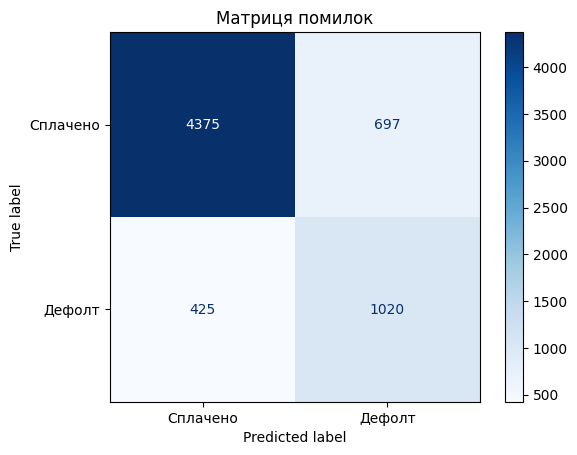

In [32]:
y_pred_opt = y_pred_proba[:,1]>=0.3
cm = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплачено', 'Дефолт'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()

Якщо модель з параметром за замовчуванням помилялась за грубими розрахунками на 5 904 000 прямих збитків і 888 800 недоотриманих витрат. То модель зі зниженим порогом - на 3 400 000 прямих збитків і 987 360 недоотриманих витрат.

На основі побудованої моделі можна зробити сегментацію кредитів за рівнем ризику дефолту:

In [33]:
# Сегментація кредитів за ймовірністю дефолту
def segment_customers(prob):
    if prob < 0.1:
        return 'Низький ризик'
    elif prob < 0.3:
        return 'Середній ризик'
    elif prob < 0.4:
        return 'Високий ризик'
    else:
        return 'Критичний ризик'

# Аналіз ризикованості кредитів
risk_segments = pd.Series(y_pred_proba[:, 1]).apply(segment_customers).value_counts()

fig = px.pie(
    values=risk_segments.values,
    names=risk_segments.index,
    title='Розподіл кредитів за ризиком дефолту',
    color_discrete_sequence=['#27ae60', '#f39c12', '#e67e22', '#e74c3c']
)
fig.show()

На графіку видно, що 20% кредитів мають критичний рівень дефолту, що говорить про те, що фінансовій організації потрібно по-перше сформувати достатні резерви під ці ризики, а по друге підвищити ефективність роботи з клієнтами щодо зниження вірогідності дефолту. Планувати реструктуризації і більш зважено підходити до оцінювання кредитоспроможності позичальника перед видачею кредиту.


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Навчаємо альтернативні моделі
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Поріг класифікації
threshold = 0.3

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Отримуємо ймовірності
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Застосовуємо поріг
    y_pred = (y_pred_proba >= threshold).astype(int)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results).round(3)
print(f"\nМетрики з порогом класифікації = {threshold}")
print("="*70)
print(results_df)


Метрики з порогом класифікації = 0.3
                 Model  Accuracy  Precision  Recall     F1    AUC
0  Logistic Regression     0.828      0.594   0.706  0.645  0.861
1        Decision Tree     0.922      0.938   0.692  0.796  0.897
2        Random Forest     0.918      0.841   0.776  0.807  0.937


Найкраща модель Random Forest, так як має найвищій AUC - краще відрізняє погашення від дефолту, а також найвищій з усіх Recall (виявлення дефолтів) та F1 (баланс між виявленням дефолтів та погашень).